# Import Data

In [8]:
# helper.py
from helper import *

In [10]:
df

,Unnamed: 0,exp,pass_accuracy_percent,pass_accuracy_percent_5y_mean,pass_accuracy_percent_5y_std,pass_accuracy_percent_career_mean,pass_accuracy_percent_career_std,pass_aimed_passes,pass_aimed_passes_5y_mean,pass_aimed_passes_5y_std,pass_aimed_passes_career_mean,pass_aimed_passes_career_std,pass_attempts,pass_attempts_5y_mean,pass_attempts_5y_std,pass_attempts_career_mean,pass_attempts_career_std,pass_avg_depth_of_target,pass_avg_depth_of_target_5y_mean,pass_avg_depth_of_target_5y_std,pass_avg_depth_of_target_career_mean,pass_avg_depth_of_target_career_std,pass_avg_time_to_throw,pass_avg_time_to_throw_5y_mean,pass_avg_time_to_throw_5y_std,pass_avg_time_to_throw_career_mean,pass_avg_time_to_throw_career_std,pass_bats,pass_bats_5y_mean,pass_bats_5y_std,pass_bats_career_mean,pass_bats_career_std,pass_big_time_throws,pass_big_time_throws_5y_mean,pass_big_time_throws_5y_std,pass_big_time_throws_career_mean,pass_big_time_throws_career_std,pass_btt_rate,pass_btt_rate_5y_mean,pass_btt_rate_5y_std,pass_btt_rate_career_mean,pass_btt_rate_career_std,pass_completion_percent,pass_completion_percent_5y_mean,pass_completion_percent_5y_std,pass_completion_percent_career_mean,pass_completion_percent_career_std,pass_completions,pass_completions_5y_mean,pass_completions_5y_std,pass_completions_career_mean,pass_completions_career_std,pass_def_gen_pressures,pass_def_gen_pressures_5y_mean,pass_def_gen_pressures_5y_std,pass_def_gen_pressures_career_mean,pass_def_gen_pressures_career_std,pass_drop_rate,pass_drop_rate_5y_mean,pass_drop_rate_5y_std,pass_drop_rate_career_mean,pass_drop_rate_career_std,pass_dropbacks,pass_dropbacks_5y_mean,pass_dropbacks_5y_std,pass_dropbacks_career_mean,pass_dropbacks_career_std,pass_drops,pass_drops_5y_mean,pass_drops_5y_std,pass_drops_career_mean,pass_drops_career_std,pass_first_downs,pass_first_downs_5y_mean,pass_first_downs_5y_std,pass_first_downs_career_mean,pass_first_downs_career_std,pass_grades_hands_fumble,pass_grades_hands_fumble_5y_mean,pass_grades_hands_fumble_5y_std,pass_grades_hands_fumble_career_mean,pass_grades_hands_fumble_career_std,pass_grades_offense,pass_grades_offense_5y_mean,pass_grades_offense_5y_std,pass_grades_offense_career_mean,pass_grades_offense_career_std,pass_grades_pass,pass_grades_pass_5y_mean,pass_grades_pass_5y_std,pass_grades_pass_career_mean,pass_grades_pass_career_std,pass_hit_as_threw,pass_hit_as_threw_5y_mean,pass_hit_as_threw_5y_std,pass_hit_as_threw_career_mean,pass_hit_as_threw_career_std,pass_interceptions,pass_interceptions_5y_mean,pass_interceptions_5y_std,pass_interceptions_career_mean,pass_interceptions_career_std,pass_passing_snaps,pass_passing_snaps_5y_mean,pass_passing_snaps_5y_std,pass_passing_snaps_career_mean,pass_passing_snaps_career_std,pass_penalties,pass_penalties_5y_mean,pass_penalties_5y_std,pass_penalties_career_mean,pass_penalties_career_std,pass_pressure_to_sack_rate,pass_pressure_to_sack_rate_5y_mean,pass_pressure_to_sack_rate_5y_std,pass_pressure_to_sack_rate_career_mean,pass_pressure_to_sack_rate_career_std,pass_qb_rating,pass_qb_rating_5y_mean,pass_qb_rating_5y_std,pass_qb_rating_career_mean,pass_qb_rating_career_std,pass_sack_percent,pass_sack_percent_5y_mean,pass_sack_percent_5y_std,pass_sack_percent_career_mean,pass_sack_percent_career_std,pass_sacks,pass_sacks_5y_mean,pass_sacks_5y_std,pass_sacks_career_mean,pass_sacks_career_std,pass_scrambles,pass_scrambles_5y_mean,pass_scrambles_5y_std,pass_scrambles_career_mean,pass_scrambles_career_std,pass_spikes,pass_spikes_5y_mean,pass_spikes_5y_std,pass_spikes_career_mean,pass_spikes_career_std,pass_thrown_aways,pass_thrown_aways_5y_mean,pass_thrown_aways_5y_std,pass_thrown_aways_career_mean,pass_thrown_aways_career_std,pass_touchdowns,pass_touchdowns_5y_mean,pass_touchdowns_5y_std,pass_touchdowns_career_mean,pass_touchdowns_career_std,pass_turnover_worthy_plays,pass_turnover_worthy_plays_5y_mean,pass_turnover_worthy_plays_5y_std,pass_turnover_worthy_plays_career_mean,pass_turnover_worthy_plays_career_std,p

In [9]:
# load data
df = pd.read_csv('./data/clean/features.csv')

# check
df.shape, len(set(df.player))

((1034, 311), 227)

- Over 1000 QB seasons for training and validation.
- 306 features (excluding player name, team, year, and target).
- 227 unique QBs.

# XGBoost

In [4]:
# non-feature cols
non_feat_cols = ['player', 'team_name', 'year', 'target']

# define X and y
X = df.drop(columns=non_feat_cols)
y = df['target']

In [ ]:
# define the parameter search space
param_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.001, 0.1),
    'gamma': (0, 1),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# run bayesian optimization
optimizer = BayesianOptimization(f=lambda max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree: 
            xgb_cv(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, X, y),
            pbounds=param_bounds,
            random_state=SEED,
            verbose=2)

# optimize for 110 iterations
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -12.27    | 0.5052    | 0.5019    | 0.05008   | 2.204     | 2.279     | 0.6093    |
| 2         | -12.65    | 0.7093    | 0.2481    | 0.009322  | 4.109     | 2.501     | 0.9393    |
| 3         | -12.69    | 0.9755    | 0.03875   | 0.07021   | 6.155     | 9.082     | 0.8334    |
| 4         | -12.34    | 0.7739    | 0.7024    | 0.03926   | 7.25      | 8.424     | 0.7328    |
| 5         | -12.48    | 0.9703    | 0.8037    | 0.09835   | 2.527     | 5.69      | 0.9728    |
| 6         | -12.47    | 0.8248    | 0.8608    | 0.09711   | 2.67      | 3.188     | 0.9367    |
| 7         | -12.33    | 0.9531    | 0.7583    | 0.03534   | 5.172     | 6.495     | 0.7481    |
| 8         | -12.41    | 0.739     | 0.4356    | 0.08717   | 2.686     | 7.189     | 0.8518    |
| 9         | -12.68

In [7]:
# get best parameters
best_params = {'colsample_bytree': 0.5161271934865836,
 'gamma': 0.5634437647901608,
 'learning_rate': 0.05682328154733499,
 'max_depth': 2,
 'min_child_weight': 2,
 'subsample': 0.5733165825944126}

# define model
xgb = XGBRegressor(**best_params, n_estimators=100, random_state=SEED, n_jobs=-1)

# cross-validation
scores = cross_validate(xgb, X, y, cv=5, scoring=['neg_root_mean_squared_error', 'r2'], n_jobs=-1)

# show results
print('MSE:', -scores['test_neg_root_mean_squared_error'].mean())
print('R²:', scores['test_r2'].mean())# access test scores

MSE: 12.396548024573931
R²: 0.30686132463989974


- The best model resulted with a CV RMSE of 12.39 and a r2 of 0.31.

# 2023 predictions
- The model will be trained on the entire train/val data, and then will predict 2023 offensive grade from the 2022 holdout set.

In [9]:
# best random forest
rf_best = RandomForestRegressor(random_state=random_state, min_samples_split=112)

# training features and target
X_train = df[all_feats]
y_train = df.target

# 2022 rows are test set
X_test = players_2022[all_feats]
y_test = players_2022.target

# create pieline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', rf_best)])

# train on entire dataset
pipeline.fit(X_train, y_train)

# predict
preds = pipeline.predict(X_test)

print(f'RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'R^2 : {r2_score(y_test, preds)}')

RMSE: 12.157436114762524
R^2 : 0.397691290884134


- Using the best random forest, we achieved an __RMSE of 12.16__. This means that on average, our 2023 predictions are 12.16 points off the true grade of a player. Our __R^2 is 0.4__, meaning that this model explains 40% of the variation in the target variable.

In [10]:
# create a df for our predictions
preds_df = pd.DataFrame(data={'player': players_2022['player'].values, 'team': players_2022['team_name'].values, 
                              'y_true': y_test, 'y_pred': preds, 'error': (preds - y_test)})

In [ ]:
# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(TEAM_COLORS)

In [12]:
# show 2023 predictions for all 48 QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']].T

,732,440,282,62,142,987,606,509,1008,976,516,878,433,165,54,542,579,540,863,831,781,334,425,920,1017,133,558,877,397,385,545,329,601,481,478,273,335,116,616,291,617,748,991,91,57,775,754,22
player,Matthew Stafford,Jared Goff,Dak Prescott,Baker Mayfield,Brock Purdy,Tua Tagovailoa,Lamar Jackson,Jordan Love,Tyrod Taylor,Trevor Lawrence,Josh Allen,Sam Howell,Jameis Winston,C.J. Beathard,Andy Dalton,Justin Fields,Kirk Cousins,Joshua Dobbs,Ryan Tannehill,Russell Wilson,Patrick Mahomes,Deshaun Watson,Jalen Hurts,Taylor Heinicke,Zach Wilson,Brian Hoyer,Kenny Pickett,Sam Darnold,Geno Smith,Gardner Minshew,Justin Herbert,Derek Carr,Kyler Murray,Joe Burrow,Jimmy Garoppolo,Cooper Rush,Desmond Ridder,Brett Rypien,Mac Jones,Daniel Jones,Malik Willis,Mike White,Tyler Huntley,Blaine Gabbert,Bailey Zappe,P.J. Walker,Mitch Trubisky,Aaron Rodgers
y_true,83.70,90.60,87.60,73.30,78.10,87.50,87.50,71.30,66.80,82.70,89.80,67.50,67.70,66.20,81.10,73.60,86.10,66.30,72.00,77.10,87.10,66.90,81.30,65.30,59.90,57.90,66.80,59.80,75.30,56.60,77.80,68.10,65.60,78.00,65.60,53.10,48.90,48.10,59.00,63.00,45.90,46.20,45.20,40.20,41.30,30.80,34.80,39.40
y_pred,61.97,72.23,72.68,59.95,65.90,75.70,75.84,60.18,57.16,73.49,80.73,59.27,59.76,58.36,74.31,66.85,79.54,59.97,65.76,71.09,81.66,61.52,77.64,62.26,56.90,54.99,63.92,58.49,74.60,57.99,79.60,71.37,69.12,81.61,70.24,58.31,55.38,56.39,68.35,73.04,58.70,59.49,60.60,56.92,60.91,55.95,62.58,78.00
error,-21.73,-18.37,-14.92,-13.35,-12.20,-11.80,-11.66,-11.12,-9.64,-9.21,-9.07,-8.23,-7.94,-7.84,-6.79,-6.75,-6.56,-6.33,-6.24,-6.01,-5.44,-5.38,-3.66,-3.04,-3.00,-2.91,-2.88,-1.31,-0.70,1.39,1.80,3.27,3.52,3.61,4.64,5.21,6.48,8.29,9.35,10.04,12.80,13.29,15.40,16.72,19.61,25.15,27.78,38.60


In [13]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

64.6% of our model's predictions are within 10 pts of the true value.


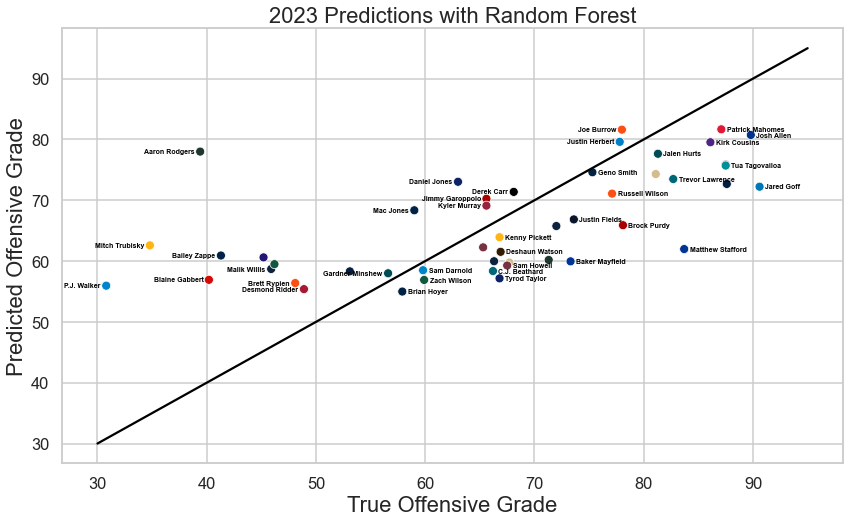

In [19]:
# visualize 2023 predictions
plt.figure(figsize=(14, 8))

# lists for annotating player names
over_drops = ['Mike White', 'Cooper Rush', 'Tyler Huntley']
under_drops = ['Jameis Winston', 'Taylor Heinicke', 'Ryan Tannehill', 'Andy Dalton', 'Dak Prescott', 'Joshua Dobbs', 
               'Lamar Jackson', 'Jordan Love']

# title, labels
plt.title('2023 Predictions with Random Forest', fontsize=22)
plt.xlabel('True Offensive Grade', fontsize=22)
plt.ylabel('Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    # over preds (above line)
    if (row['y_pred'] > row['y_true']) and (row['player'] not in over_drops):
        plt.text(row['y_true']-0.5, row['y_pred']-0.3, row['player'], horizontalalignment='right', color='black', 
             weight='semibold', fontsize=7)
    # under preds (below line)
    elif (row['y_pred'] < row['y_true']) and (row['player'] not in under_drops):
        plt.text(row['y_true']+0.5, row['y_pred']-0.3, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
             
plt.savefig('./images/preds_1');

- Each point represents a single player in 2023. The distance from the black line is how far off our prediction was. Ideally, a perfect model would only have dots on the line. 
- Dots above the line are cases in which our model __overpredicted__ the player's performance, and dots below the line are __underpredictions__.
- You can see that the worst prediction, by far, is __Aaron Rodgers__, with an error of 38.6. It should be noted that he was injured on the 4th play of the 2023 season with a torn achilles, so this point is definitely an outlier.

In [17]:
# all 48 QBs
print(f'Normal - RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'Normal - R^2 : {r2_score(y_test, preds)}\n')

# dropping aaron rodgers
print(f'Dropping Aaron Rodgers - RMSE: {mean_squared_error(y_test[1:], preds[1:], squared=False)}')
print(f'Dropping Aaron Rodgers - R^2 : {r2_score(y_test[1:], preds[1:])}')

Normal - RMSE: 12.157436114762524
Normal - R^2 : 0.397691290884134

Dropping Aaron Rodgers - RMSE: 10.920073785075424
Dropping Aaron Rodgers - R^2 : 0.492223269173908


- If we drop this point, our RMSE goes from a __12.16 to a 10.92__, and R^2 leaps from a __0.4 to a 0.49__.

In [18]:
# percent of preds within 10 pts
percent = (preds_df[1:].error.abs() < 10).sum() / (len(preds_df) - 1)

print(f'Excluding Aaron Rodgers, {percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

Excluding Aaron Rodgers, 66.0% of our model's predictions are within 10 pts of the true value.
